<a href="https://colab.research.google.com/github/painterV/some_coding/blob/main/homework05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5

Due December 11, 2022 at 11:59pm.

Select `File -> Download As -> Notebook (.ipynb)` and upload your submission to Gradescope.

## Congressional Re-Tweeting

The United States Congress, composed of the House of Representatives and the Senate, is seated on a two year basis (while Senators sit for 6 year terms, elections for the Senate are staggered such that composition still changes on a two year cycle). These two year periods are labeled in order, with the 115th Congress occuring in the years 2017-2018.

[Researchers at UM's School of Information collected Twitter posts from sitting MoCs](https://www.openicpsr.org/openicpsr/project/108303/version/V2/view) (we'll abbreviate "member of Congress" as **MoC**) during this period and coded them as being original statements or rewteets of other users' submissions. We will focus on the retweet data. These published data include not only the text of the retweet but also information on the member of Congress and the account of the original tweet.

In this assignment, we'll consider whether relationships exist between useage of retweeting and different parties, ages, house of Congress, and features of the original source account.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import os

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.options.mode.chained_assignment = None

**Set your section number:**

In [ ]:
section = "100"

In the following we will load the data, though for reasons of speed we will exclude the text of the tweets themselves.

In [ ]:
# base = "/scratch/stats206s%sf22_class_root/stats206s%sf22_class/materials/data" % (section, section)
base = "./"
tweets = pd.read_csv(os.path.join(base, "retweets_congress_115th.csv.gz"), 
                     usecols = lambda x: x != "full_text",
                     dtype = {"tweet_id_str": "str"},
                     index_col = "tweet_id_str")

In [ ]:
tweets.shape

(209856, 21)

In [90]:
tweets.columns

Index(['user_id_str', 'user_screen_name', 'user_followers_count', 'created_at',
       'retweet_count', 'retweeted_status', 'year', 'bioguide', 'birthday',
       'gender', 'name', 'state', 'chamber', 'party', 'region', 'rt_user_id',
       'rt_screen_name', 'rt_followers_count', 'rt_bio', 'age', 'age_bucket',
       'party_is_Democrat', 'is_congress_retweet'],
      dtype='object')

## Question 1

In the following section we are going to perform inference on this data set. To do so, we need to think about these data as a sample from a population. Before beginning our data analysis, we will define some important terms and describe a sampling process will think makes sense for this setting.

### Part (a)

In your own words, define a **population**. What are the common features of all populations? Does a population have to be a set of things we that physically exist in the world? 


**Answer:**

In statistics, a population refers to any collection of specified group of human beings or of
non-human entities such as objects, educational institutions, time units, geographical areas,
prices of wheat or salaries drawn by individuals. Some statisticians call it universe.

The common features of all populations are massive, homogeneity and variability.

No exactly. A population can be a set of things without physical body.

### Part (b)

In your own words, define a **sample**. Why do we have to analyze samples instead of populations? What is the connection between a population and a sample? 

**Answer:**

A sample is a random selection of members of a population. 

In most cases, a population can be too large to collect accurate data – which is not practical. Samples offer a representation of the whole population if sampled accordingly. Samples allow researchers to collect data that can be analyzed to provide insights into the entire population.

It is a smaller group drawn from the population that has the characteristics of the entire population. The observations and conclusions made against the sample data are attributed to the population as a whole.

### Part (c)

What population would we like to study using the sample of retweets? In forming your answer, think about how time might play a role. Also consider whether you could describe a **data generating process** that creates retweets.

There is no exact answer to these questions, but the important part is to make an effort that could convenince others.

**Answer:**

The population that we would like to study is the set of all retweet behavior of all previous MoC in each session.

Time just plays a sample dimension role.

## Question 2

### Part (a)

Congress is largely composed of two parties (Democrats and Republicans), with a few independents. Which party is responsible for most of the retweets?

Compute the marginal probability of the party of the tweet and save the result to `party_marg`. Display this result.

In [93]:
party_marg = tweets["party"].value_counts(normalize=True)
print(party_marg)

max_responsible_part = party_marg.idxmax()
print(max_responsible_part, " is responsible for most of the retweets")

Democrat       0.588176
Republican     0.407493
Independent    0.004330
Name: party, dtype: float64
Democrat  is responsible for most of the retweets


**Answer:**

Democrat  is responsible for most of the retweets.

### Part (b)

One question we might ask is, "How often do Congress members retweet each other?"

Create a new column called `"is_congress_retweet"` that will indicate if the retweet is coming from a MoC. First get the set of unique `"user_id_str"` values using the `.unique()` method. Then using that set of ids, use the `.isin(values)` method on the `"rt_user_id"` column to create the new boolean column `"is_congress_retweet"`.

Find the marginal probability of retweeting a MoC and save the result to `"congress_retweet_marg"`. Display these results. Is it more common to retweet a member of Congress or from outside of Congress?

In [94]:
tweets["is_congress_retweet"] = tweets["rt_user_id"].isin(tweets["user_id_str"].unique())

tweets["is_congress_retweet"].value_counts(dropna = False)

congress_retweet_marg = tweets["is_congress_retweet"].mean()

print(congress_retweet_marg)

if congress_retweet_marg > 0.5:
    print("it is more common to retweet a member of Congress")
elif congress_retweet_marg < 0.5:
    print("it is more common to retweet from outside of Congress")
else:
    print("same common")
# 0.19129784232997865
# it is more common to retweet from outside of Congress

0.19129784232997865
it is more common to retweet from outside of Congress


**Answer:**

The probability of Congress members retweet each other is 0.19129784232997865.

The probability indicates that it is more common to retweet from outside of Congress.

### Part (c)

Do the parties retweet each other at the same rates?

* Calcuate the counts of retweets by each party (`"party_cong_retweet_counts"`).
* Calculate and display the joint probability of party and whether the retweet comes from a MoC. Call this table "`party_cong_retweet_joint`".
* Calculate the conditional probability of retweeting a MoC conditioning on the party. Feel free to use the marginal probabilities you already calculated in Part (a).

Which party has the higher conditional probability of retweeting a MoC? Why did we need to calculate the conditional probability instead of just using the joint probabilities to answer the question "Do the parties retweet each other at the same rates?"


In [ ]:
party_cong_retweet_counts = tweets["party"].value_counts(dropna = False)
party_cong_retweet_counts

party_cong_retweet_joint = tweets.groupby(["party", "is_congress_retweet"]).size().unstack()
party_cong_retweet_joint

probs = party_cong_retweet_joint / party_cong_retweet_joint.sum().sum()
probs

# party_marg_v2 = probs.sum(1)

party_cond = probs.div(party_marg, axis = 0)
party_cond

is_congress_retweet,False,True
Democrat,0.771414,0.228586
Independent,0.817778,0.182222
Republican,0.859288,0.140712


**Answer:**

Democrat has the higher conditional probability of retweeting a MoC. 

Conditional probability is the probability of one event occurring in the presence of a second event. We use the conditional probability instead of just using the joint probabilities to determine whether retweet is more likely from a member of MoC when the party is already known.

### Part (d)

If party and rewteeting a MoC are independent in the population you described in 1(c), then the joint distribuiton of these measurements should be close to the product of the marginal probabilities. 

Create the probabilities we would expect to see if party and MoC retweeting were independent (call this table `"party_cong_retweet_indep"`). Recall the function `np.outer` is useful for this purpose.

Display this table and comment if it looks like the table of joint probabilities from 1(c).

In [ ]:
# party_marg_v2 = probs.sum(1)

reMoC_marg = tweets["is_congress_retweet"].value_counts(normalize=True)

# reMoC_cond = probs.div(reMoC_marg, axis = 1)
# reMoC_cond
print("joint_probs: \n", probs)
party_cong_retweet_indep = np.outer(party_marg, reMoC_marg)
print("party_cong_retweet_indep: \n", party_cong_retweet_indep)

# party_cong_retweet_indep is obviously different from joint probabilities from 1(c)

joint_probs: 
 is_congress_retweet     False      True
party                                  
Democrat             0.453727  0.134449
Independent          0.003541  0.000789
Republican           0.350154  0.057339
party_cong_retweet_indep: 
 [[0.47565931 0.11251683]
 [0.32954086 0.07795262]
 [0.00350199 0.00082839]]


**Answer:**

```party_cong_retweet_indep``` is obviously different from joint probabilities from 1(c)

## Question 3

In this question will we extend the results of question 2 to perform a formal hypothesis test that party and member retweeting are independent.

### Part (a)

In your own words, describe a hypothesis test. Make sure to define the null hypothesis, alternative hypothesis, and critical value. Under what circumstances to you reject a null hypothesis? Under what circumstances to you fail to reject the null hypothesis?

**Answer:**

A falsifiable hypothesis is a statement, or hypothesis, that can be contradicted with evidence. In empirical (data-driven) research, this evidence will always be obtained through the data. 

In statistical hypothesis testing, the hypothesis that we formally test is called the null hypothesis. 

The alternative hypothesis is a second hypothesis that is our proposed explanation for what happens if the null hypothesis is wrong.

---------more 


### Part (b)

Calculate the Pearson residuals from for party and MoC retweeting by calculating the expected counts of under independence, the difference from the observed counts, and then dividing by the square root of the expected counts. 

In [103]:
resid = probs - party_cong_retweet_indep
resid
n = party_cong_retweet_joint.sum().sum()
diff_counts = resid * n
expected_ind = n * party_cong_retweet_indep

pr = (n * resid) / np.sqrt(n * party_cong_retweet_indep)
pr

is_congress_retweet,False,True
party,,
Democrat,-14.497228,29.807409
Independent,-258.893228,-125.995499
Republican,2670.516903,895.097855


### Part (c)

Are any of the values outside of the range (-3,3)? What would you conclude about values outside of this range?

**Answer:**

All of the values are outside of the range (-3, 3). From values outside of this range, the expected counts do not appear to fit well for the observed counts.

As a rule of thumb, Pearson residuals that are smaller than 2 in magnitude are completely compatible with X and Y being independent. Values between 2 are 3 are suggestive of non-independence, and values above 3 are strongly suggestive of non-independence.

### Part (d)

We can combine all of these individual tests for each cell into a composite test by squaring and summing the values.

At a 95% confidence level, we would reject the hypothesis that party and congressional retweeting are independent if the sum of squared deviations exceeds 5.99. (remember to use `.sum().sum()` to get the sum for the entire table)

Do we reject the hypothesis of independence?

In [108]:
pr.pow(2).sum().sum()

8016859.9191770535

**Answer:**

Yes. We reject the hypothesis of independence because the sum of squared deviations exceeds 5.99

## Question 4

In this question we will aggregate up to the level of individual MoCs to investigate questions of how MoCs behave with respect to retweeting behavior.

### Part (a)

Aggregate (`groupby` and `agg`) the retweeting data using the `user_id_str` column. Use the following functions for the respective columns:

* `first`: `gender`, `chamber`, `party`, `region`, `age_bucket`, `age`
* `max`: `user_followers_count`
* `mean`: `rt_followers_count`

Save these results as `moc_retweets`.

Compute (and display) the conditional mean of `user_followers_count` given `age_bucket`. Which age group has the highest average number of followers?

In [116]:
moc_retweets = hh = tweets.groupby('user_id_str').agg({'gender': 'first',
                                     'chamber': 'first',
                                     'party': 'first',
                                     'region': 'first',
                                     'age_bucket': 'first',
                                     'age': 'first',
                                     'user_followers_count': 'max',
                                     'rt_followers_count': 'mean'
                                    })
counts = hh.groupby(["age_bucket"]).agg({'user_followers_count': 'mean'})
print(counts)

            user_followers_count
age_bucket                      
30                 125286.692308
40                 109522.742857
50                  92983.139706
60                  71047.931034
70                 223842.628866
80                 260131.034483


**Answer:**

Group of 80 age_bucket has the highest average number of followers 260131.

### Part (b)

Now aggregate up the number of retweets per MoC from the `tweets` table using the `.size()` method after grouping by `user_id_str`. 

Add this information to the `moc_retweets` table as a new column `"retweets"`.

Create a box plot of the number of retweets (y-axis) against the party of the MoC (x-axis) (use the `showfliers = False` option).

<!-- Which party's member tend to have higher amount of retweeting activity -->

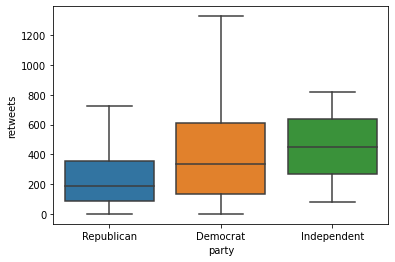

In [123]:
moc_retweets["retweets"] = tweets.groupby('user_id_str').size()

sb.boxplot(data = moc_retweets, x = "party", y = "retweets", showfliers = False)

### Part (c)

Perform a difference of means test of comparing the number of retweets by Republicans and Democrats (ignore independents). Would you reject the null hypothesis that these two groups have the same average number of retweets?

## Question 5

In this section, we ask, "Do popular MoCs (in the sense of having many followers) tend to retweet popular tweets or do they amplify unknown sources?"

### Part (a)

Using a KDE plot, plot the marginal distributions of the maximum number of followers a MoC had (`"user_followers_counts"`) and the average number of followers of the retweeted user (`"rt_followers_count"`) from the `moc_retweets` table.

Comment on these distributions. Do you think that a transformation would be beneficial?

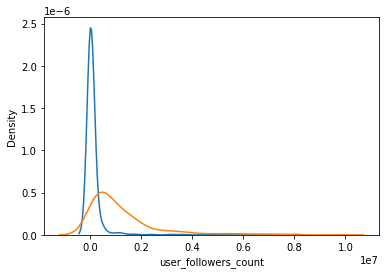

In [130]:
sb.kdeplot(x = moc_retweets['user_followers_count'])
sb.kdeplot(x = moc_retweets['rt_followers_count'])

**Answer:**

From distributions we can see MoCs with lower followers retweet more. But 

### Part (b)

Plot a scatter plot of the transformation (if you selected one) of `user_followers_count` on the x-axis and  the transformation of `"rt_followers_count"` (if you selected one) on the y-axis from the `moc_retweets` table. What kind of trend do you observe?

In [ ]:
sb.scatterplot(data = moc_retweets, x = "user_followers_count", y = "rt_followers_count")


### Part (c)

Compute the correlation between the variables plotted in the previous plot. Peform a hypothesis test of the this value for the hypothesis that the population correlation is zero at the significance level $\alpha = 0.05$.

### Part (d)

We might be interested if accounting for age influences our understanding of the relationship of MoC followers and average retweet followers. 

Compute a linear regression of the (transformed) number of MoC followers with (transformed) RT followers and age. Perform a hypothesis test for the RT followers coefficient. Interpret this result and comment on what we can conclude from these results.